### Machine Learning (C24), Spring 2024, Project Group F
-----
# Polynomial Regression Model
This notebook fits a polynomial regression (Lasso) model for the dataset at **df_clean.csv** and outputs a comparative data table of common regression (y-num) metrics.

Data
- y target is `'price actual'`
- X features
    - given: national energy data, weather features from five cities (one-hot-encoded)
    - extracted: tume variables, previous three hours of `'price actual'`
    - **choice of polynomial features**

Models fitted (scikit-learn):
1. `Lasso` (cross-validated +1SE) ⬅️ given that Lasso performed best in [linear_regression.ipynb](./linear_regression.ipynb)

Evaluation metrics:
1. MSE, RMSE, R$^2$, MAE, MAPE
2. Plots: y vs. $\hat{y}$, residuals vs. $\hat{y}$, residual historgram, Bias-Variance Tradeoff: MSE vs. alpha
3. Feature importance (coefficients)

In [1]:
# Import libraries
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from collections import defaultdict

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import project functions
import sys
sys.path.append('../')
from functions import prep_split, add_model_eval, model_eval_plot, regression_coef_plot, polynomial_terms

In [2]:
# Output options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Preparation

Steps:
1. **Choose and create polynomial features**
    - `PolynomialFeatures` is a litte strange as is always includes interaction terms so creating our own function `polynomial_terms`
    - Ran a few subsets of features to square
    - Try powers up to 8 (!)
2. Split X/y, train/test
3. Standardize X

In [31]:
df = pd.read_csv('../Data/df_clean.csv', index_col="time", parse_dates=['time'])
df.shape #(35061, 91)

(35061, 91)

## 1. Lasso Regression

In [52]:
# Setup time-series cross-validation
tscv = TimeSeriesSplit(n_splits=2)

# Setup degrees
degree_scores = defaultdict(list)
degree_scores['max_degrees'] = np.arange(1, 9, 1) #1..8

# Setup model evaluation dictionary
model_eval = dict()

# Setup y
y_col = ['price actual']

In [53]:
#x_poly = ['price_prev_1', 'price_prev_2', 'price_prev_3']
xgboost_top10 = ['price_prev_1', 'price day ahead', 'hour', 'price_prev_2', 'price_prev_3', 'forecast solar day ahead', 'generation solar', 'generation other renewable', 'temp_Madrid', 'temp_Seville']

# Degrees loop
for degree in degree_scores['max_degrees']: #1..6
    df_poly = polynomial_terms(df, xgboost_top10, degree)

    # "prep_split" includes dropping specified columns, then standardizing all remaining X (but not y)
    X_train, X_test, y_train, y_test = prep_split(df_poly,
                                                  columns_drop=y_col, #default: just drop y from X
                                                  label=y_col,
                                                  train_end_date='2017-12-31 23:00:00+00:00',
                                                  hours_ahead=0) #default: don't shift y

    # Setup alphas
    lasso_scores = defaultdict(list)
    lasso_scores['alphas'] = np.logspace(-5, 5, 20)
    
    # Alpha parameter loop
    for alpha in lasso_scores['alphas']:
        # Do CV with Lasso model
        lasso_model = Lasso(alpha=alpha)
        scores = cross_val_score(lasso_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

        # Per-alpha: calculate scores average and SE
        lasso_scores['avg_mse'].append(-1 * np.mean(scores))
        lasso_scores['std_errors'].append(np.std(scores) / np.sqrt(len(scores)))
        
    # Choose alpha based on One Standard Error Rule: min MSE + 1SE
    df_lasso_scores = pd.DataFrame(lasso_scores)
    within_one_std = df_lasso_scores['avg_mse'].min() + df_lasso_scores['std_errors'][df_lasso_scores['avg_mse'].idxmin()]
    best_alpha_lasso = max([df_lasso_scores['alphas'][i] for i, mse in enumerate(df_lasso_scores['avg_mse']) if mse <= within_one_std])
    best_std_error = df_lasso_scores['std_errors'][df_lasso_scores.index[df_lasso_scores['alphas'] == best_alpha_lasso][0]]
    
    # Ridge model with best alpha: #1. Create #2. Fit #3. Predict
    best_lasso_model = Lasso(alpha=best_alpha_lasso)
    best_lasso_model.fit(X_train, y_train)
    y_pred_lasso = best_lasso_model.predict(X_test)

    # 4a. Evaluate
    key = f'Lasso Polynomial Regression - degrees up to {degree}'
    model_eval = add_model_eval(model_eval, key, y_test, y_pred_lasso)
    model_eval[key]['max_degrees'] = degree
    model_eval[key]['best_alpha'] = best_alpha_lasso
    model_eval[key]['best_std_error'] = best_std_error

In [54]:
df_model_eval = pd.DataFrame(model_eval).T
df_model_eval

,MSE,RMSE,R2,MAE,MAPE,max_degrees,best_alpha,best_std_error
Lasso Polynomial Regression - degrees up to 1,7.530739,2.744219,0.949477,1.869069,0.033337,1.0,0.048329,1.155614
Lasso Polynomial Regression - degrees up to 2,6.560553,2.561358,0.955986,1.804164,0.032151,2.0,0.004281,0.111505
Lasso Polynomial Regression - degrees up to 3,6.642517,2.577308,0.955436,1.800049,0.031964,3.0,0.014384,0.186179
Lasso Polynomial Regression - degrees up to 4,6.695029,2.587475,0.955084,1.807255,0.032073,4.0,0.014384,0.211175
Lasso Polynomial Regression - degrees up to 5,6.697590,2.587970,0.955066,1.807064,0.032083,5.0,0.014384,0.223885
Lasso Polynomial Regression - degrees up to 6,6.615067,2.571977,0.955620,1.812621,0.032265,6.0,0.004281,0.175841
Lasso Polynomial Regression - degrees up to 7,6.611306,2.571246,0.955645,1.811890,0.032261,7.0,0.004281,0.175277
Lasso Polynomial Regression - degrees up to 8,6.701605,2.588746,0.955039,1.807033,0.032101,8.0,0.014384,0.209400


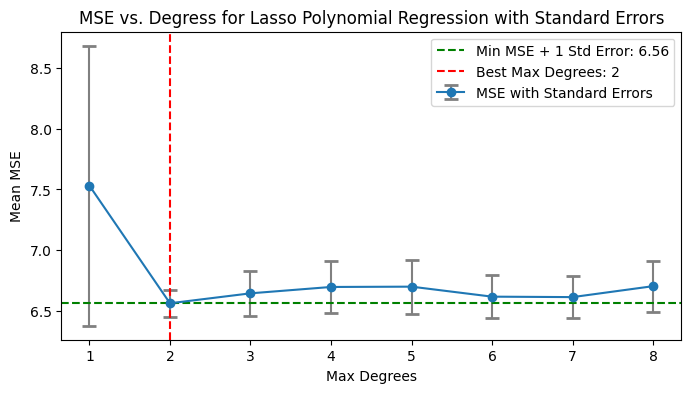

In [59]:
# Plotting MSE vs Alpha with standard error bars
fig, axes = plt.subplots(figsize=(8, 4))
plt.errorbar(df_model_eval['max_degrees'], df_model_eval['MSE'], yerr=df_model_eval['best_std_error'], fmt='-o', ecolor='gray', capsize=5, capthick=2, label='MSE with Standard Errors')

# Degrees and MSE lines for chosen point
best_mse = df_model_eval['MSE'].min()
plt.axhline(y=best_mse, color='green', linestyle='--', label=f'Min MSE + 1 Std Error: {round(best_mse,2)}')

best_max_degree = int(df_model_eval['max_degrees'][df_model_eval.index[df_model_eval['MSE'] == best_mse][0]])
plt.axvline(x=best_max_degree, color='red', linestyle='--', label=f'Best Max Degrees: {best_max_degree}')

# Plot customizations
plt.xlabel('Max Degrees')
plt.ylabel('Mean MSE')
plt.title('MSE vs. Degress for Lasso Polynomial Regression with Standard Errors')
plt.legend()
plt.show()

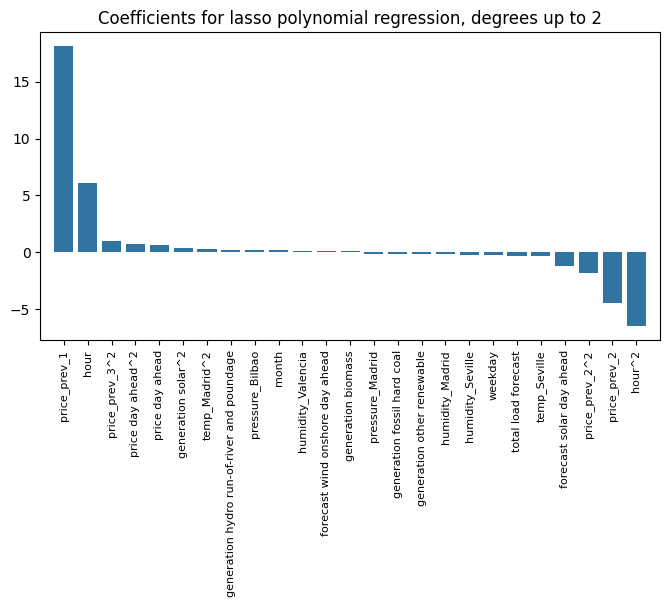

In [61]:
# 4c. Interpret
fig, axes = plt.subplots(figsize=(8, 4))

# Re-create ridge model with best max degrees: #1. Create #2. Fit #3. Predict
df_poly = polynomial_terms(df, xgboost_top10, best_max_degree)
X_train, X_test, y_train, y_test = prep_split(df_poly,
                                              columns_drop=y_col, #default: just drop y from X
                                              label=y_col,
                                              train_end_date='2017-12-31 23:00:00+00:00',
                                              hours_ahead=0) #default: don't shift y

best_alpha_by_degree = df_model_eval['best_alpha'][df_model_eval.index[df_model_eval['max_degrees'] == best_max_degree][0]]
best_lasso_model_by_degree = Lasso(alpha=best_alpha_by_degree)
best_lasso_model_by_degree.fit(X_train, y_train)

regression_coef_plot(best_lasso_model_by_degree, fig, axes, 0.1, f'Coefficients for lasso polynomial regression, degrees up to {best_max_degree}')

### Commentary
**Observations:**
- Interestingly, creating squared terms for the xGBoost top 10 features list does **descrease RMSE from 2.74 to 2.56** with Lasso regression (cross-validated +1SE)
- With these features, the **best max degress is still 2** but there is also a local minimum at 6

**Analysis:**
- The most influencing coefficients include the square terms for `'hour'`, `'price_prev_2'`, and `'price_prev_3'`
- Perahps this means that these are even more important features than shown with only linear regression?